In [1]:
%pip install opencv-python


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import tensorflow as tf
import numpy as np
import cv2
import os

from tensorflow.keras import layers, models
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from keras.utils import to_categorical

import matplotlib.pyplot as plt

import seaborn as sns

from string import ascii_uppercase

from tqdm import tqdm

## 1) Carregando imagens

In [4]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if os.path.isdir(label_path):
            for filename in tqdm(os.listdir(label_path), desc=f"Loading {label} images"):
                img_path = os.path.join(label_path, filename)
                if img_path.endswith(".jpg") or img_path.endswith(".png"):
                    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
                    images.append(img)
                    labels.append(label)
    return images, labels

## 2) Construindo rede própria

In [5]:
def simple_CNN_model(optimizer="adam", input_shape = (64, 64, 3), num_classes = 21):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

    # model.summary()
    return model

### 2.1) Pré-processando dados

In [6]:
# Definir classes (letras do alfabeto, excluindo H, J, K, X e Z)
classes = [letter for letter in ascii_uppercase if letter not in {'H', 'J', 'K', 'X', 'Z'}]

num_classes = len(np.unique(classes))

print(f'Classes: {classes}')
print(f'Número de classes: {num_classes}')

Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']
Número de classes: 21


In [7]:
label_encoder = LabelEncoder()
X_train, y_train = load_images_from_folder('../libras_dataset/train')
X_test, y_test = load_images_from_folder('../libras_dataset/test')
X_train = np.array(X_train) / 255
X_test = np.array(X_test) / 255
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

# Dividir o conjunto de treinamento em treinamento e validação
# X_train, X_val, y_train_one_hot, y_val_one_hot = train_test_split(X_train, y_train_one_hot, test_size=0.2, random_state=42)

Loading A images:   0%|          | 0/1686 [00:00<?, ?it/s]

Loading Y images: 100%|██████████| 550/550 [00:00<00:00, 1851.86it/s]


In [8]:
print(X_train.shape)
print(X_train[0].shape)
print(set(y_train))

(34714, 64, 64, 3)
(64, 64, 3)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}


### 2.2) Treinamento do modelo

In [9]:
model = simple_CNN_model()

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

In [11]:
# tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [12]:
model = KerasClassifier(build_fn = simple_CNN_model)
#What hyperparameter we want to play with
parameters = {'batch_size': [4, 16],
              'optimizer': ['adam', 'rmsprop', 'sgd']}

grid_search = GridSearchCV(estimator = model,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 3)
grid_result = grid_search.fit(X_train, y_train_one_hot, return_train_score=True)

C:\Users\gabri\AppData\Local\Temp\ipykernel_18228\1887873824.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = simple_CNN_model, verbose=1)


KeyboardInterrupt: 

In [ ]:
# history = model.fit(X_train, y_train_one_hot, epochs=10, validation_data=(X_val, y_val_one_hot))

### 2.4) Avaliando treinamento do modelo

In [ ]:
print("Best accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

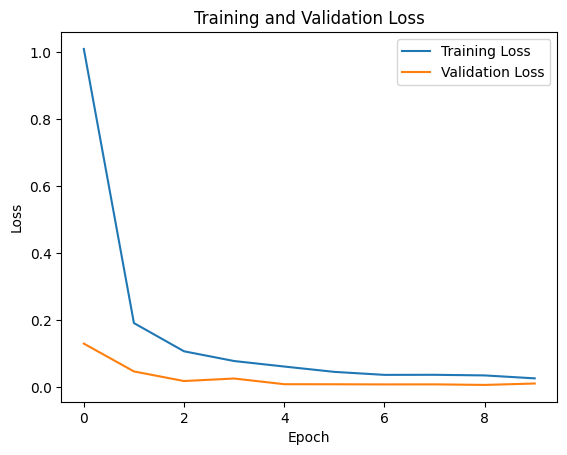

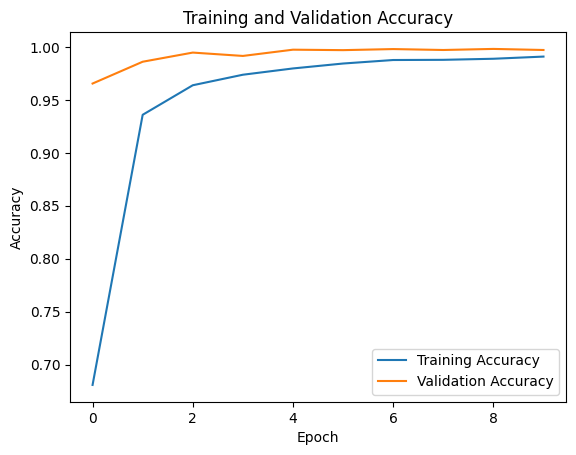

In [ ]:
# Plotar o gráfico de Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotar o gráfico de Acurácia
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 2.5) Teste do melhor modelo

In [ ]:
best_model = grid_result.best_estimator_.model

In [ ]:
predictions = best_model.predict(X_test)

# Converter as probabilidades de volta para rótulos de classe usando np.argmax
predicted_labels = np.argmax(predictions, axis=1)

# Converter rótulos one-hot-encoded para rótulos de classe
y_test_classes = np.argmax(y_test_one_hot, axis=1)

361/361 [==============================] - 4s 11ms/step


### 2.6) Avaliando teste do modelo

#### 2.6.1) Matriz de confusão

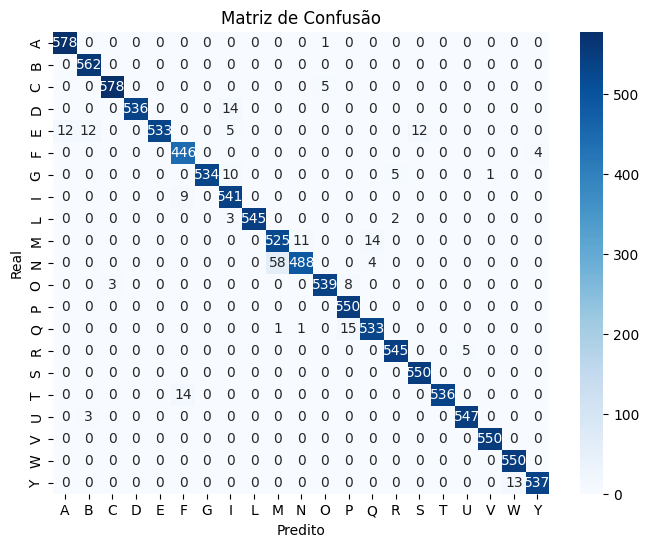

In [ ]:
# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test_classes, predicted_labels)

# Exibir a matriz de confusão usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

#### 2.6.2) Métricas de eficácia

In [ ]:

classif_report = classification_report(y_test_classes, predicted_labels)
accuracy = accuracy_score(y_test_classes, predicted_labels)
f1 = f1_score(y_test_classes, predicted_labels, average='weighted')  # Escolha a opção apropriada

print("\nAcurácia:")
print(accuracy)

print("\nF1-score:")
print(f1)

print("\nRelatório de Classificação:")
print(classif_report)


Acurácia:
0.9787842050571528

F1-score:
0.978748000603281

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       579
           1       0.97      1.00      0.99       562
           2       0.99      0.99      0.99       583
           3       1.00      0.97      0.99       550
           4       1.00      0.93      0.96       574
           5       0.95      0.99      0.97       450
           6       1.00      0.97      0.99       550
           7       0.94      0.98      0.96       550
           8       1.00      0.99      1.00       550
           9       0.90      0.95      0.93       550
          10       0.98      0.89      0.93       550
          11       0.99      0.98      0.98       550
          12       0.96      1.00      0.98       550
          13       0.97      0.97      0.97       550
          14       0.99      0.99      0.99       550
          15       0.98      1.00      0.99    